# Fine-Tuned Historian (Structure Aware Generation - Storytelling)

Here we finetume TinyLlama on TinyStories dataset to see if we can make a better historian for our multimodal systems. The big question is would it be better/worse than using a dictionary memory or is there a reasonable use case for both?

## Setup

In [1]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
from transformers import (
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    EarlyStoppingCallback,
)

print(torch.__version__)
print(torch.cuda.is_available())

2.7.1
False


In [2]:
dataset = load_dataset("roneneldan/TinyStories", split="train", cache_dir="../.cache")
dataset = dataset.shuffle(seed=42).select(range(10000))

dataset[0]

{'text': 'Tim and Mia like to play in the park. They see a big club on the ground. It is brown and long and heavy.\n\n"Look, a club!" Tim says. "I can lift it!"\n\nHe tries to lift the club, but it is too tough. He falls down and drops the club.\n\n"Ouch!" he says. "That hurt!"\n\nMia laughs. She is not mean, she just thinks it is funny.\n\n"Let me try!" she says. "I can balance it!"\n\nShe picks up the club and puts it on her head. She walks slowly and carefully. She does not fall down.\n\n"Wow!" Tim says. "You are good at balancing!"\n\n"Thank you!" Mia says. "It is fun!"\n\nThey take turns balancing the club on their heads, arms, and legs. They have a lot of fun with the club. They are happy and proud. They are good friends.'}

In [3]:
print(f"Dataset size: {len(dataset)}")

Dataset size: 10000


## Preprocessing

Tokenize the stories using TinyLlama's tokenizer (ensures alignment with the target model’s input expectations)

In [4]:
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_id)
base_model = AutoModelForCausalLM.from_pretrained(model_id)

The tokenizer converts raw text into a sequence of tokens (subwords). For example "Hello, world!" might be tokenized into ["Hello", ",", "world", "!"]. 

THe tokenizer object here also encodes the tokens with tensors

In [5]:
def tokenize(batch):
    tokens = tokenizer(
        batch["text"], truncation=True, padding="max_length", max_length=512
    )
    tokens["labels"] = tokens["input_ids"].copy()  # 🎯 Use same tokens as targets
    return tokens

In [6]:
tokenized_dataset = dataset.map(tokenize, batched=True)

In [7]:
# make sure dataset returns labels: 'input_ids', 'attention_mask', 'labels'
print(tokenized_dataset[0].keys())

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])


In [8]:
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(
    f"Model input names: {tokenizer.model_input_names}"
)  # this is a list of keys that the model expects so the model can consume it
# Example usage of the tokenizer
print(tokenizer.tokenize("Hello!"))
print(tokenizer.convert_tokens_to_ids(["Hello", "!"]))
# Example usage of the tokenizer
print(tokenizer("Hello world!", return_tensors="pt"))

Vocabulary size: 32000
Model input names: ['input_ids', 'attention_mask']
['▁Hello', '!']
[10994, 29991]
{'input_ids': tensor([[    1, 15043,  3186, 29991]]), 'attention_mask': tensor([[1, 1, 1, 1]])}


The model object contains all of the model's parameters and architecture.

In this case we are working with a decoder-only transformer (processes text left to right and predicts the next token at each step).

input_ids → embed_tokens → [x22 LlamaDecoderLayer] → norm → lm_head → logits

Where each LlamaDecoderLayer does (attention → norm) → (MLP → norm)

In [9]:
# print(model.config)
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

In [10]:
total_params = sum(p.numel() for p in base_model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 1,100,048,384


So, we are working with a 1.1B parameter model and a dataset of 10k stories on fairly minimal hardware. 

| Data-to-Parameter Ratio  | Recommended Strategy                    |
|--------------------------|-----------------------------------------|
| **1 : 1,000,000+**        | Use **LoRA** or adapters only           |
| **1 : 100,000 – 1,000,000** | Freeze most layers, tune only top few  |
| **1 : 1,000 – 100,000**   | Partial unfreeze (e.g., last 2–4 layers)|
| **1 : <1,000**            | Full fine-tuning is feasible            |

SO rule of thumb says we'd probably want to freeze most of the layers or use LoRA since our data-to-parameter ratio is **1 : 110,000**...let's try it.

## Fine-Tuning using LoRA

In [11]:
lora_config = LoraConfig(
    r=8,  # size of the low-rank matrices
    lora_alpha=32,  # scaling factor for the LoRA updates
    target_modules=["q_proj", "v_proj"],  # apply LoRA only to these layers
    lora_dropout=0.05,  # dropout rate for the LoRA layers
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

In [12]:
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [14]:
# test: confirm that the model accepts and computes loss
sample = tokenized_dataset[0]
input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0)
attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0)
labels = torch.tensor(sample["labels"]).unsqueeze(0)

output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
print(output.keys())
# Should include 'loss'

odict_keys(['loss', 'logits', 'past_key_values'])


In [ ]:
training_args = TrainingArguments(
    output_dir="../.cache/historian_model",  # where to save the model
    # batch size controls the number of samples processed in parallel...bigger batches have more stable gradients but require more memory so more GPU power would allow larger batches. Since we are working on a CPU/low memory situation and its a fairly small model we'll try 1-4
    per_device_train_batch_size=4,
    # since we are using a pretrained model and small dataset (and no GPU), 1-3 epoch for fine-tuning are probably enough. Starting with 1 for quick test/diagnostics run is good
    num_train_epochs=1,
    logging_steps=50,  # how often to log training progress
    save_steps=500,  # how often to save the model
    fp16=False,  # use mixed precision training for faster training on GPUs
    save_total_limit=1,  # keep only the latest model checkpoint
    report_to="none",  # disable reporting to any logging service
    # max_steps=300,  # past runs show that loss levels off after ~300 steps, so we can limit training to that (or use early stopping callback below)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3)
    ],  # stop training if no improvement after 3 steps
)

/var/folders/hq/4zf8zzj14kx2rpg0wjq7rdh80000gn/T/ipykernel_23383/2588874555.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Lets do a quick dry run time estimate.

In [ ]:
# then multiply this by total steps to get a time estimate
# trainer.train(max_steps=10)

Great so now we are training and we can see the progress...

number of step is total examples / batch size

- the epochs are one full pass through the whole dataset
- the steps are the batches

[current step of / 2500 steps total, time elapsed < estimated time, iteration speed (steps/sec), epoch (current/total)]

In [ ]:
trainer.train(
    # resume_from_checkpoint=True
)

/Users/yarik/vc_projects/ML/deep-learning/.venv-py31013/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,3.639800
100,0.676100
150,0.641600
200,0.641900
250,0.645100
300,0.639800
350,0.625600
400,0.601900
450,0.613200
500,0.621800


KeyboardInterrupt: 

Loss pretty much leveled out so we can stop training early.

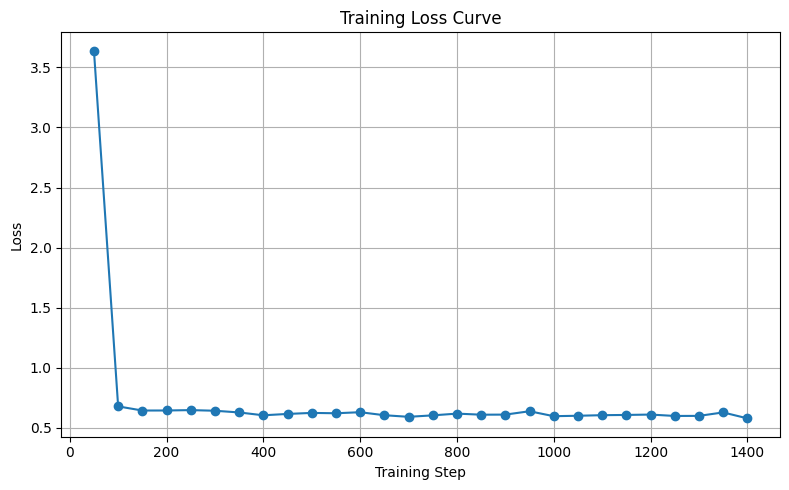

In [18]:
import matplotlib.pyplot as plt

# Extract steps and losses from trainer's log history
steps = []
losses = []

for log in trainer.state.log_history:
    if "loss" in log and "step" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker="o", linestyle="-")
plt.title("Training Loss Curve")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Clearly for more efficient training in the future we can stop after 300 steps or so.

## Fine-Tuning using Layer Freezing

In [11]:
# Freeze all layers in the base model transformer
for param in base_model.model.parameters():
    param.requires_grad = False

# Unfreeze the last N transformer layers
N = 1  # lets try unfreezing the last 2 layers
for layer in base_model.model.layers[-N:]:
    for param in layer.parameters():
        param.requires_grad = True

# Unfreeze the final output (language modeling) head
for param in base_model.lm_head.parameters():
    param.requires_grad = True

# Print how many parameters will be updated
trainable = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in base_model.parameters())
print(f"Trainable: {trainable:,} / {total:,} ({trainable / total:.2%})")

Trainable: 109,580,288 / 1,100,048,384 (9.96%)


I expect this to be slower than LoRA since its updating more of the model (10%) but lets see.

In [14]:
training_args = TrainingArguments(
    output_dir="../.cache/historian_model_frz",  # where to save the model
    # batch size controls the number of samples processed in parallel...bigger batches have more stable gradients but require more memory so more GPU power would allow larger batches. Since we are working on a CPU/low memory situation and its a fairly small model we'll try 1-4
    per_device_train_batch_size=4,
    # since we are using a pretrained model and small dataset (and no GPU), 1-3 epoch for fine-tuning are probably enough. Starting with 1 for quick test/diagnostics run is good
    num_train_epochs=1,
    logging_steps=50,  # how often to log training progress
    save_steps=500,  # how often to save the model
    fp16=False,  # use mixed precision training for faster training on GPUs
    save_total_limit=1,  # keep only the latest model checkpoint
    report_to="none",  # disable reporting to any logging service
    # max_steps=300,  # past runs show that loss levels off after ~300 steps, so we can limit training to that (or use early stopping callback below)
    metric_for_best_model="loss",  # use loss as the metric to determine the best model
    eval_strategy="steps",  # evaluate the model every few steps
    eval_steps=250,  # evaluate every X steps
    greater_is_better=False,  # lower loss is better
    load_best_model_at_end=True,  # load the best model at the end of training
)

trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,  # use the same dataset for evaluation
    tokenizer=tokenizer,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2)
    ],  # stop training if no improvement after 3 steps
)

/var/folders/hq/4zf8zzj14kx2rpg0wjq7rdh80000gn/T/ipykernel_30114/3583897076.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
trainer.train(
    # resume_from_checkpoint=True
)

/Users/yarik/vc_projects/ML/deep-learning/.venv-py31013/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

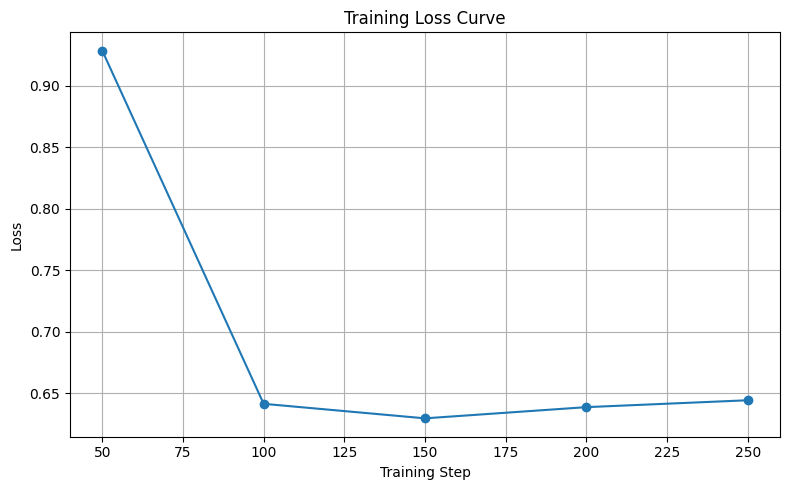

In [16]:
import matplotlib.pyplot as plt

# Extract steps and losses from trainer's log history
steps = []
losses = []

for log in trainer.state.log_history:
    if "loss" in log and "step" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker="o", linestyle="-")
plt.title("Training Loss Curve")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Time and loss was similar to LoRA for this model and dataset size.